In [1]:
#%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/GaussFit_spec2D.py
#%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py

%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
import astropy.constants as constants

import sys
import os
dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"

sys.path.append(dir_BinnedFit)
from binnedFit_utilities import *
from imageFit import ImageFit
from chainTool import ChainTool
from gen_mocks import gen_mock_tfCube

sys.path.append(dir_KLens)
from KLtool import *
from tfCube2 import GalaxyImage, TFCube

In [2]:
###### set up parameters ######

line_species='Halpha'

pars = {}
pars['g1'] = 0.0
pars['g2'] = 0.0
pars['sini'] = 0.5

pars['redshift'] = 0.4

pars['aspect'] = 0.2
pars['r_hl_image'] = 0.5
pars['r_hl_spec'] = 0.5

pars['theta_int'] = 0. #np.pi/3.

pars['slitWidth'] = 0.12
pars['ngrid'] = 128

pars['norm'] = 0.0

pars['Resolution'] = 5000.
pars['expTime'] = 60.*30. #60.*30.
pars['pixScale'] = 0.1185
pars['nm_per_pixel'] = 0.033
pars['throughput'] = 0.29
pars['psfFWHM'] = 0.5

pars['area'] = 3.14 * (1000./2.)**2 

pars['vcirc'] = 200.

linelist = np.empty(5,dtype=[('species',np.str_,16),
                                  ('lambda',np.float),
                                  ('flux',np.float)])
linelist['species'] = ['OIIa','OIIb','OIIIa','OIIIb','Halpha']
linelist['lambda'] =  [372.7092,372.9875,496.0295,500.8240,656.461]

fiber_SDSS = np.pi * 1.5**2
refSDSSspec = 3.*1e-17 * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)

linelist['flux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]

pars['linelist'] = linelist

In [3]:
dataInfo = gen_mock_tfCube(pars, 'Halpha', slits='major', noise_mode=0)

/Users/hhg/Research/kinematic_lensing/repo/BinnedFit/notebook/../../BinnedFit/../TNGcube/TNGcube.py:835: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 324x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdc11174a10>)

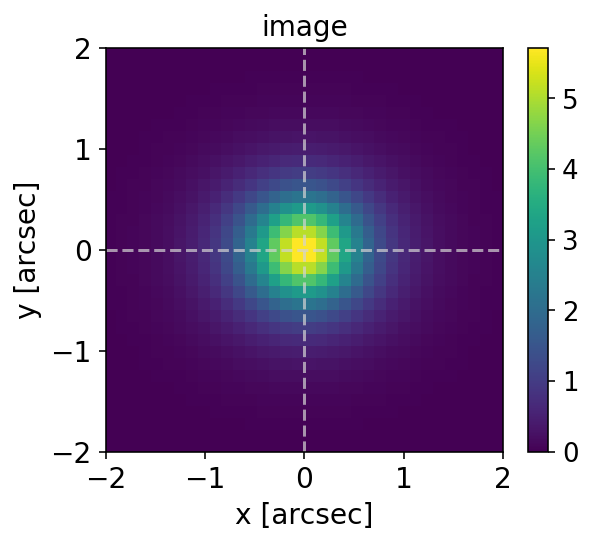

In [4]:
dataInfo['image'].display(xlim=[-2,2])

In [5]:
ImFit = ImageFit(image=dataInfo['image'], par_init = dataInfo['par_fid'])

In [6]:
chainInfo = ImFit.run_MCMC(Nwalker=50, Nsteps=1000, active_par_key=['e_obs', 'r_hl_image', 'theta_int', 'flux'], par_fix={'g1':0., 'g2':0.})

100%|██████████| 1000/1000 [00:53<00:00, 18.59it/s]

Total MCMC time (mins): 0.8973132491111755


In [7]:
active_par_test = np.zeros(len(ImFit.active_par_key))
for j, item in enumerate(ImFit.active_par_key):
    active_par_test[j] = ImFit.par_init[item]
active_par_test

array([1.36363636e-01, 5.00000000e-01, 0.00000000e+00, 5.22303772e+02])

In [8]:
%time loglike = ImFit.cal_loglike(active_par=active_par_test)
loglike

CPU times: user 1.84 ms, sys: 605 µs, total: 2.45 ms
Wall time: 1.86 ms


-0.0

In [9]:
Chain_Image = ChainTool(chainInfo, Nburn=25000, Nend=50000)

In [10]:
Chain_Image.par_bestfit(select_par_key=['e_obs', 'r_hl_image', 'theta_int', 'flux'], statistics='max', mode=0)

{'e_obs': [0.1047680872676537, 0.12803665819882118, 0.16347885233238751],
 'r_hl_image': [0.4912762431827585, 0.4978474795066608, 0.5094026970037644],
 'theta_int': [-0.10769871962079114,
  -0.0006490641830694255,
  0.12224475278053903],
 'flux': [514.1419272072784, 523.3481047696364, 531.6607230607333]}

In [11]:
Chain_Image.par_maxlike(select_par_key=['flux'])

(array([522.66464148]), -0.005439016968011856)

In [12]:
from chainconsumer import ChainConsumer

blue        = "#214F94"
red         = "#CC0204"
yellow      = "#FFA903"
gray        = "#858278"
black       = "#000000"
green       = "#73ab24"
purple      = "#8600C8"
lightblue   = "#6898FF"
lightblue2  = "#82b9e6"
yellowgreen = "#8dcd32" #"#8DE900"
lightteal   = "#7FC2BF"
teal        = "#51ABAE"
lightgray   = "#CDCDCD"

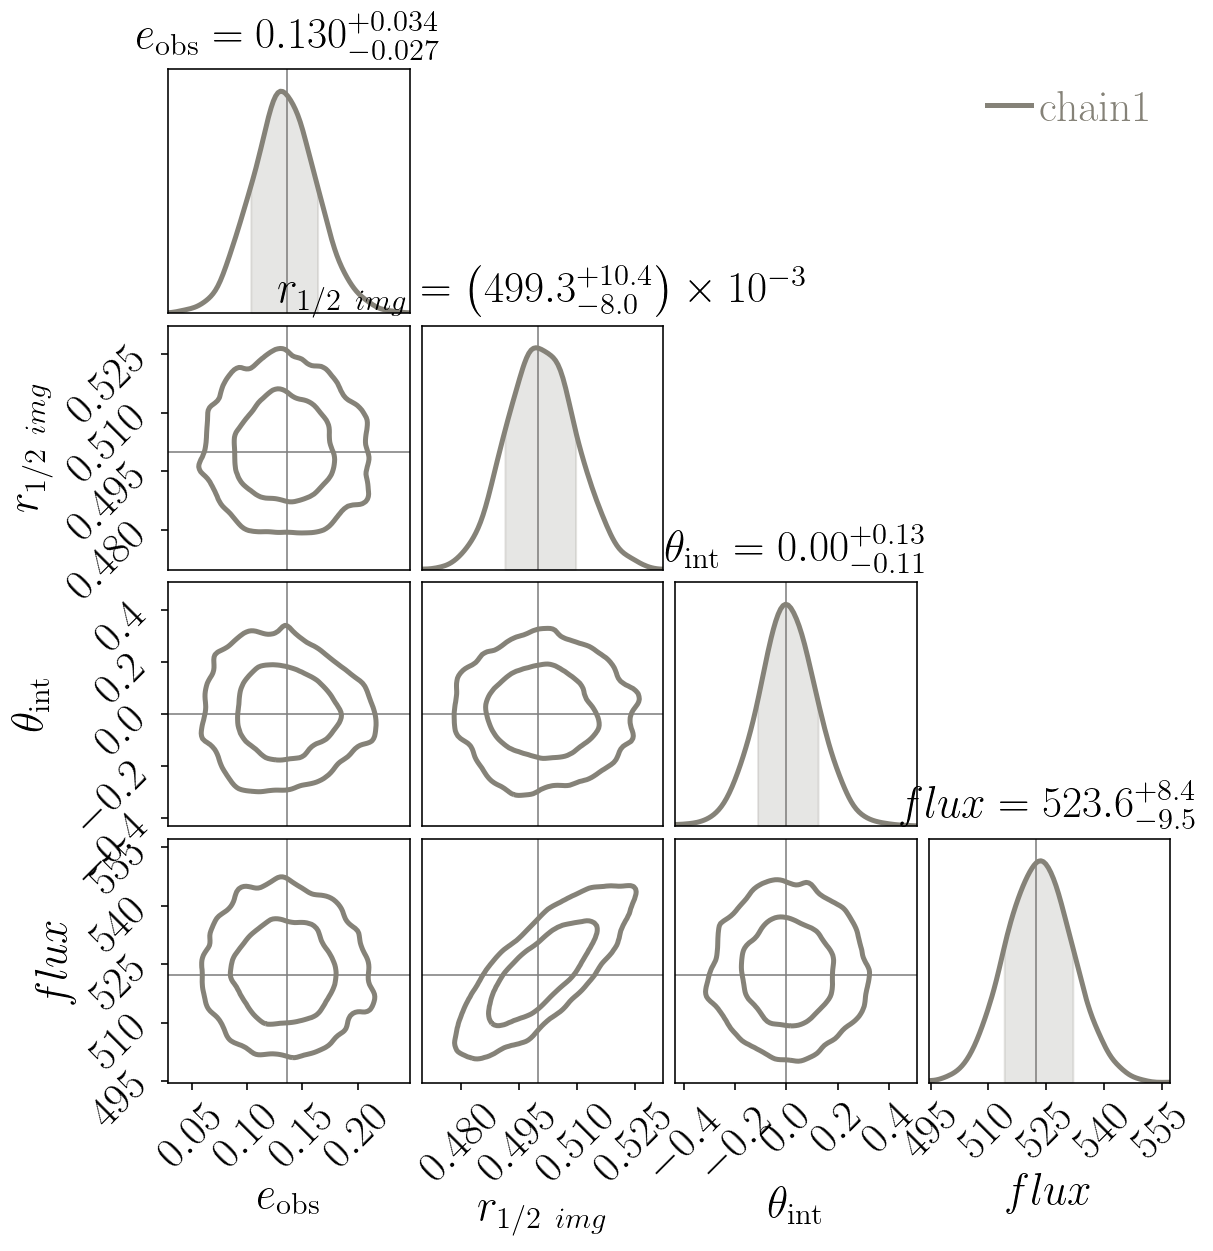

In [13]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['e_obs','r_hl_image','theta_int','flux']

parID1,parName1,par_x1 = Chain_Image.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain_Image.chain[:, parID1], parameters=parName1 ,name="$\mathrm{chain1}$")


c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=22,tick_font_size=22
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)

c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
truth_pt = [Chain_Image.par_fid[item] for item in ImFit.active_par_key]
fig = c.plotter.plot(legend=True, truth=truth_pt) #, truth=par_x1

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)